# LSTM:
   ## Pros:
1) LSTM is well-suited for sequential data like MIDI sequences because it can capture dependencies and patterns over time.

2) It's relatively simpler to implement compared to WaveNet.

3) LSTM models are often more interpretable, making it easier to understand how they generate music.


In [2]:
import numpy as np
import tensorflow as tf
import pandas as pd
from matplotlib import pyplot as plt

In [3]:
import math

#### pretty_midi:
Used for handling MIDI files in a convenient and intuitive way.

#### fluidsynth:
Allows for MIDI file playback and synthesis, converting MIDI data into audio waveforms.

#### pyfluidsynth:
A Python wrapper for FluidSynth, providing a Python interface to interact with FluidSynth's functionalities.



In [4]:
!pip install pretty_midi
!sudo apt install -y fluidsynth
!pip install --upgrade pyfluidsynth

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 16.9 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 6.8 MB/s eta 0:00:00
  Created wheel for pretty_midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592306 sha256=49be7372adbc0d6fb4e2f5257e0cf01558b3c90f09407e395e76433faad34900
  Stored in directory: /root/.cache/pip/wheels/1f/54/f1/fca57848157fc8f2cbb513575f242d517eb0e44f14e4179a52
Successfully built pretty_midi
  Attempting uninstall: packaging
    Found existing installation: packaging 21.3
    Uninstalling packaging-21.3:
      Successfully uninstalled packaging-21.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask-cudf 21.10.1 requires cupy-cuda114, which is not installed.
beatrix-

In [5]:
sampling_rate = 10000

In [6]:
import collections
import datetime
import fluidsynth
import glob
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
from IPython import display
from typing import Dict, List, Optional, Sequence, Tuple

In [7]:
filenames = glob.glob(str("../input/music-midi-dataset/midi_dataset/**/*.mid*"))

In [8]:
sample_file ="../input/music-midi-dataset/midi_dataset/midi_dataset/x (11).mid"
pm = pretty_midi.PrettyMIDI(sample_file)

/opt/conda/lib/python3.7/site-packages/pretty_midi/pretty_midi.py:104: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  RuntimeWarning)


**Enables quick and easy visualization and playback of synthesized audio generated from MIDI data.**

In [9]:
def display_audio(pm, seconds=30):
      waveform = pm.fluidsynth(fs=sampling_rate)
  # Take a sample of the generated waveform to mitigate kernel resets
      waveform_short = waveform[:seconds*sampling_rate]
      return display.Audio(waveform_short, rate=sampling_rate)

In [10]:
display_audio(pm,50)

fluidsynth: warning: SDL2 not initialized, SDL2 audio driver won't be usable
fluidsynth: warning: SDL2 not initialized, SDL2 audio driver won't be usable
fluidsynth: warning: SDL2 not initialized, SDL2 audio driver won't be usable
fluidsynth: warning: SDL2 not initialized, SDL2 audio driver won't be usable


In [11]:
print(pm.instruments)
instrument = pm.instruments[0]

[Instrument(program=91, is_drum=False, name="Lead"), Instrument(program=73, is_drum=False, name="Voice"), Instrument(program=87, is_drum=False, name="Bass"), Instrument(program=0, is_drum=True, name="Drums")]


In [12]:
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)

In [13]:
# for i , note in enumerate(instrument.notes[:10]):
#     note_name = pretty_midi.note_number_to_name(note.pitch)
#     duration = note.end - note.start
#     print(f"{i}: pitch = {note.pitch} , note_name = {note_name} , duration = {duration:.4f}")

**Converts MIDI data into a structured format (DataFrame) suitable for further analysis or processing.**

In [14]:
def midi_to_notes(midi_file):
    pm = pretty_midi.PrettyMIDI(midi_file)
    instrument = pm.instruments[0]
    notes = collections.defaultdict(list)
    sorted_notes = sorted(instrument.notes , key=lambda note:note.start)
    prev_start = sorted_notes[0].start
    
    for note in sorted_notes:
        start = note.start
        end = note.end
        notes["pitch"].append(note.pitch)
        notes["start"].append(start)
        notes["end"].append(end)
        notes["step"].append(start - prev_start)
        notes["duration"].append(end - start)
        prev_start = start
    return pd.DataFrame({name:np.array(value) for name,value in notes.items()})

In [15]:
raw_notes = midi_to_notes(sample_file)
raw_notes.head()

,pitch,start,end,step,duration
0,77,0.00,0.25,0.00,0.25
1,77,1.00,1.25,1.00,0.25
2,75,1.75,2.00,0.75,0.25
3,77,2.00,2.25,0.25,0.25
4,79,2.25,2.50,0.25,0.25


In [16]:
note_names = np.vectorize(pretty_midi.note_number_to_name)
sample_note_names = note_names(raw_notes["pitch"])
sample_note_names[:10]

array(['F5', 'F5', 'D#5', 'F5', 'G5', 'C5', 'D#5', 'F5', 'F5', 'D#5'],
      dtype='<U3')

In [17]:
def plot(notes , count):
    if count:
        title = f"first {count} notes"
    else:
        title = f"whole track"
        count = len(notes["pitch"])
    plt.figure(figsize=(20,4))
    plot_pitch = np.stack([notes["pitch"] , notes["pitch"]],axis = 0)
    plot_start_stop = np.stack([notes["start"] , notes["end"]] ,axis = 0)
    print(plot_start_stop.shape)
    plt.plot(plot_start_stop[:,:count] , plot_pitch[:,:count] , color ="r" ,marker = "*")
    plt.xlabel("Time [s]")
    plt.ylabel("pitch")
    plt.title = title

(2, 23)


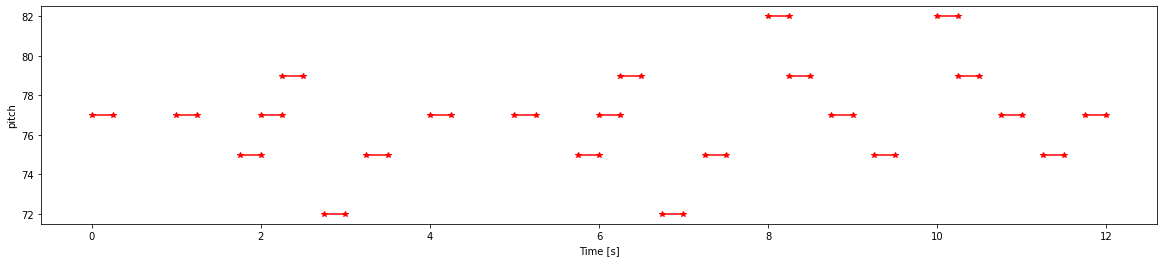

In [18]:
plot(raw_notes , count=100)

**Converts structured note data (DataFrame) into a MIDI file format.**

In [19]:
def notes_to_midi(notes: pd.DataFrame,out_file: str, instrument_name: str,velocity: int = 100) -> pretty_midi.PrettyMIDI:
    pm = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

    prev_start = 0
    for i, note in notes.iterrows():
        start = float(prev_start + note['step'])
        end = float(start + note['duration'])
        note = pretty_midi.Note(velocity=velocity,pitch=int(note['pitch']),start=start,end=end,)
        instrument.notes.append(note)
        prev_start = start

    pm.instruments.append(instrument)
    pm.write(out_file)
    return pm

In [20]:
num_files = 5 
all_notes = []
for f in filenames[:num_files] :
    notes = midi_to_notes(f)
    all_notes.append(notes)
all_notes = pd.concat(all_notes)
    

/opt/conda/lib/python3.7/site-packages/pretty_midi/pretty_midi.py:104: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  RuntimeWarning)


In [21]:
print(all_notes)

    pitch   start        end   step  duration
0      73   7.875   8.000000  0.000  0.125000
1      76   8.000   8.208333  0.125  0.208333
2      76   8.250   8.375000  0.250  0.125000
3      76   8.375   8.500000  0.125  0.125000
4      76   8.500   8.625000  0.125  0.125000
..    ...     ...        ...    ...       ...
47     64  79.000  79.250000  0.250  0.250000
48     62  79.250  79.375000  0.250  0.125000
49     69  79.500  79.625000  0.250  0.125000
50     69  79.875  80.000000  0.375  0.125000
51     66  80.125  80.250000  0.250  0.125000

[830 rows x 5 columns]


In [22]:
n_notes = len(all_notes)
print(n_notes)

830


In [23]:
key_order = ["pitch" , "step" , "duration"]
train_notes = np.stack([all_notes[key] for key in key_order] , axis = 1)

In [24]:
print(train_notes[:20,0])

[73. 76. 76. 76. 76. 76. 76. 73. 76. 76. 76. 76. 76. 76. 76. 76. 80. 80.
 80. 83.]


In [25]:
notes_ds=tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

TensorSpec(shape=(3,), dtype=tf.float64, name=None)

In [26]:
seq_length = 20
vocab_size = 128


In [27]:
print(train_notes.shape)

(830, 3)


**Prepares input-output pairs (sequences and corresponding targets) for training a machine learning model.**

In [28]:
def create_sequences(dataset,seq_length,vocab_size=128):
    sequences = []
    targets = []
    num_seq = train_notes.shape[0] - seq_length
    for i in range(num_seq):
        sequence = train_notes[i:i+seq_length - 1,:] / [vocab_size, 1 ,1]
        target =  train_notes[i+seq_length] / vocab_size
        sequences.append(sequence)
        targets.append(target)
    sequences = np.array(sequences)
    targets = np.array(targets)
    print(sequences.shape , targets.shape)
    dataset = tf.data.Dataset.from_tensor_slices((sequences,{"pitch":targets[:,0] , "step":targets[:,1] ,"duration" :targets[:,2]}))
    return dataset

In [29]:
seq_ds = create_sequences(notes_ds, 21, vocab_size)

(809, 20, 3) (809, 3)


In [30]:
for seq, target in seq_ds.take(1):
    print("sequence shape: " , seq.shape )
    print("sequence elements " ,seq[0:10])
    print()
    print("target ", target)

sequence shape:  (20, 3)
sequence elements  tf.Tensor(
[[0.5703125  0.         0.125     ]
 [0.59375    0.125      0.20833333]
 [0.59375    0.25       0.125     ]
 [0.59375    0.125      0.125     ]
 [0.59375    0.125      0.125     ]
 [0.59375    0.125      0.125     ]
 [0.59375    0.25       0.125     ]
 [0.5703125  0.25       0.125     ]
 [0.59375    0.125      0.125     ]
 [0.59375    0.125      0.125     ]], shape=(10, 3), dtype=float64)

target  {'pitch': <tf.Tensor: shape=(), dtype=float64, numpy=0.625>, 'step': <tf.Tensor: shape=(), dtype=float64, numpy=0.0009765625>, 'duration': <tf.Tensor: shape=(), dtype=float64, numpy=0.0009765625>}


In [31]:
batch_size =64
buffer_size = 5000
train_ds = seq_ds.shuffle(buffer_size).batch(batch_size)
test_ds = seq_ds.shuffle(5000).batch(64)

In [32]:
train_ds.element_spec

(TensorSpec(shape=(None, 20, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(None,), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(None,), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(None,), dtype=tf.float64, name=None)})

# Model Architecture:
- Defines a sequential model using TensorFlow Keras.
- Specifies the input shape as (seq_length, 3) where seq_length represents the length of each input sequence and 3 represents the number of features (pitch, step, duration).
- Adds an LSTM layer with 128 units (neurons) to the model.
- Constructs the model's output using three dense layers:

    1) One for predicting pitch with 128 units and softmax activation.
    
    2) One for predicting step with 1 unit and linear activation.
    
    3) One for predicting duration with 1 unit and linear activation.
- Loss Functions:
   - Defines loss functions for each output:
        - Sparse Categorical Crossentropy loss for predicting pitch.(suitable for categorical classification problems where the target variable (pitch in this case) has multiple classes (128 in this case))
        - Mean Squared Error (MSE) loss for predicting step and duration.(commonly used for regression tasks)
- Optimizer:
   - Specifies the Adam optimizer with a learning rate of 0.005.
- Compilation:
   - Compiles the model using the specified loss functions, loss weights, and optimizer.
- Loss Weights:
   - Assigns different weights to each output's loss:
       - 0.05 for pitch loss.
       - 1.0 for step loss.
       - 1.0 for duration loss.


In [33]:
layer = tf.keras.layers
learning_rate = 0.005
input_data = tf.keras.Input(shape=(seq_length , 3))
x= layer.LSTM(128)(input_data)
outputs = {
    "pitch":tf.keras.layers.Dense(128 , name = "pitch")(x),
    "step":tf.keras.layers.Dense(1 , name = "step")(x),
    "duration":tf.keras.layers.Dense(1 , name = "duration")(x),
}
model1 = tf.keras.Model(input_data , outputs)

loss  ={
    "pitch" : tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
    "step": tf.keras.losses.MeanSquaredError(),
    "duration":tf.keras.losses.MeanSquaredError(),
}

optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
model1.compile(loss=loss ,    loss_weights={
        'pitch': 0.05,
        'step': 1.0,
        'duration':1.0,
    }, optimizer = optimizer)

model1.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 20, 3)]      0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 128)          67584       input_1[0][0]                    
__________________________________________________________________________________________________
duration (Dense)                (None, 1)            129         lstm[0][0]                       
__________________________________________________________________________________________________
pitch (Dense)                   (None, 128)          16512       lstm[0][0]                       
______________________________________________________________________________________________

In [34]:
model1.fit(train_ds , epochs = 100)

Epoch 1/100
13/13 [==============================] - 5s 5ms/step - loss: 0.2278 - duration_loss: 0.0111 - pitch_loss: 4.2888 - step_loss: 0.0023
Epoch 2/100
13/13 [==============================] - 0s 5ms/step - loss: 0.0592 - duration_loss: 0.0202 - pitch_loss: 0.1335 - step_loss: 0.0323
Epoch 3/100
13/13 [==============================] - 0s 5ms/step - loss: 0.0093 - duration_loss: 0.0077 - pitch_loss: 0.0103 - step_loss: 0.0011
Epoch 4/100
13/13 [==============================] - 0s 5ms/step - loss: 0.0024 - duration_loss: 7.8739e-04 - pitch_loss: 0.0069 - step_loss: 0.0013
Epoch 5/100
13/13 [==============================] - 0s 5ms/step - loss: 0.0011 - duration_loss: 1.7563e-04 - pitch_loss: 0.0052 - step_loss: 6.3600e-04
Epoch 6/100
13/13 [==============================] - 0s 5ms/step - loss: 6.4709e-04 - duration_loss: 1.0779e-04 - pitch_loss: 0.0039 - step_loss: 3.4452e-04
Epoch 7/100
13/13 [==============================] - 0s 5ms/step - loss: 5.2559e-04 - duration_loss: 4.403

In [35]:
hist = model1.predict(train_ds)
print(hist["duration"].shape)

(809, 1)


In [36]:
print(hist["step"].shape)

(809, 1)


In [37]:
def predict_next_note(
notes , keras_model , temperature):
    
    assert temperature > 0 
    inputs = np.expand_dims(notes , 0)
    predictions = model1.predict(inputs)
    pitch_logits = predictions['pitch']
    step = predictions["step"]
    duration = predictions["duration"]
    pitch_logits /= temperature
    pitch = tf.random.categorical(pitch_logits , num_samples = 1)
    pitch = tf.squeeze(pitch , axis = -1)
    duration = tf.squeeze(duration , axis =-1)
    step = tf.squeeze(step,axis = -1)
    step = tf.maximum(0,step)
    duration = tf.maximum(0 , duration)
    return int(pitch) , float(step) , float(duration)

In [38]:
temperature = 2.0
num_predictions = 1200

sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

# The initial sequence of notes; pitch is normalized similar to training
# sequences
input_notes = (sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))
generated_notes = []
prev_start = 0
for _ in range(num_predictions):
    pitch, step, duration = predict_next_note(input_notes, model1, temperature)
    start = prev_start + step
    end = start + duration
    input_note = (pitch, step, duration)
    generated_notes.append((*input_note, start, end))
    input_notes = np.delete(input_notes, 0, axis=0)
    input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
    prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))
print("Done!!")

Done!!


In [39]:
generated_notes.head(40)


,pitch,step,duration,start,end
0,0,0.006273,0.004868,0.006273,0.011141
1,0,0.000450,0.005925,0.006723,0.012648
2,0,0.001256,0.005822,0.007980,0.013801
3,0,0.001223,0.005788,0.009203,0.014990
4,0,0.001237,0.005803,0.010440,0.016243
5,0,0.001249,0.005805,0.011689,0.017494
6,0,0.001263,0.005795,0.012952,0.018748
7,0,0.001284,0.005786,0.014236,0.020022
8,0,0.001303,0.005757,0.015539,0.021295
9,122,0.001318,0.005697,0.016857,0.022554


In [40]:
out_file = 'output1.mid'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=instrument_name)
display_audio(out_pm , 50)

fluidsynth: warning: SDL2 not initialized, SDL2 audio driver won't be usable


# WaveNet

In [41]:
import tensorflow as tf 

### Running this script using GPU is recommended

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from collections import Counter
import random
import matplotlib.pyplot as plt #library for visualiation
from sklearn.model_selection import train_test_split

from keras.layers import *
from keras.models import *
from keras.callbacks import *
import keras.backend as K
from keras.models import load_model

import seaborn as sns

#For data visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

# Listing current data on our folder.
import os
print(os.listdir("."))

['output1.mid', '.virtual_documents']


In [42]:
pip install music21

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.4/22.4 MB 30.8 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [43]:
#library for understanding music
from music21 import *
def read_midi(file):
    
    print("Loading Music File:",file)
    
    notes=[]
    notes_to_parse = None
    
    #parsing a midi file
    midi = converter.parse(file)
  
    #grouping based on different instruments
    s2 = instrument.partitionByInstrument(midi)

    #Looping over all the instruments
    for part in s2.parts:
    
        #select elements of only piano
        if 'Piano' in str(part): 
        
            notes_to_parse = part.recurse() 
      
            #finding whether a particular element is note or a chord
            for element in notes_to_parse:
                
                #note
                if isinstance(element, note.Note):
                    notes.append(str(element.pitch))
                
                #chord
                elif isinstance(element, chord.Chord):
                    notes.append('.'.join(str(n) for n in element.normalOrder))

    return np.array(notes)

In [44]:
#specify the path
#path='../input/maestropianomidi/maestro-v3.0.0/2018/'
path = '../input/beethoven-midi/'

#read all the filenames
files=[i for i in os.listdir(path) if i.endswith(".mid")]

#reading each midi file
notes_array = np.array([read_midi(path+i) for i in files])

Loading Music File: ../input/beethoven-midi/beethoven_opus22_3.mid


/opt/conda/lib/python3.7/site-packages/music21/midi/translate.py:885: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=5, channel=None, data=b'Copyright \xa9 2009 by Bernd Krueger'>; getting generic Instrument
  TranslateWarning)


Loading Music File: ../input/beethoven-midi/pathetique_1.mid


/opt/conda/lib/python3.7/site-packages/music21/midi/translate.py:885: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=4, channel=None, data=b'Beethoven Sonata No. 8 C minor, Grand Sonate path\xe9tique 1. Movement'>; getting generic Instrument
  TranslateWarning)
/opt/conda/lib/python3.7/site-packages/music21/midi/translate.py:885: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=5, channel=None, data=b'Copyright \xa9 2003 by Bernd Krueger'>; getting generic Instrument
  TranslateWarning)


Loading Music File: ../input/beethoven-midi/beethoven_opus22_2.mid
Loading Music File: ../input/beethoven-midi/waldstein_2.mid
Loading Music File: ../input/beethoven-midi/beethoven_opus22_4.mid
Loading Music File: ../input/beethoven-midi/beethoven_hammerklavier_4.mid


/opt/conda/lib/python3.7/site-packages/music21/midi/translate.py:885: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=5, channel=None, data=b'Copyright \xa9 2008 by Bernd Krueger'>; getting generic Instrument
  TranslateWarning)


Loading Music File: ../input/beethoven-midi/mond_3.mid


/opt/conda/lib/python3.7/site-packages/music21/midi/translate.py:885: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=0, channel=None, data=b'Mondscheinsonate; der Gr\xe4fin Giulietta Guiccardi gewidmet'>; getting generic Instrument
  TranslateWarning)
/opt/conda/lib/python3.7/site-packages/music21/midi/translate.py:885: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=5, channel=None, data=b'Copyright \xa9 1998 by Bernd Krueger'>; getting generic Instrument
  TranslateWarning)


Loading Music File: ../input/beethoven-midi/appass_1.mid


/opt/conda/lib/python3.7/site-packages/music21/midi/translate.py:885: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=5, channel=None, data=b'Copyright \xa9 2001 by Bernd Kr\xfcger'>; getting generic Instrument
  TranslateWarning)


Loading Music File: ../input/beethoven-midi/elise.mid


/opt/conda/lib/python3.7/site-packages/music21/midi/translate.py:885: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=0, channel=None, data=b'F\xfcr Elise'>; getting generic Instrument
  TranslateWarning)
/opt/conda/lib/python3.7/site-packages/music21/midi/translate.py:885: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=3, channel=None, data=b'Beethoven F\xfcr Elise'>; getting generic Instrument
  TranslateWarning)
/opt/conda/lib/python3.7/site-packages/music21/midi/translate.py:885: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=4, channel=None, data=b'Copyright \xa9 2004 by Bernd Kr\xfcger'>; getting generic Instrument
  TranslateWarning)


Loading Music File: ../input/beethoven-midi/appass_3.mid
Loading Music File: ../input/beethoven-midi/pathetique_2.mid


/opt/conda/lib/python3.7/site-packages/music21/midi/translate.py:885: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=6, channel=None, data=b'Beethoven Sonata No. 8 C minor, Grand Sonate path\xe9tique 2. Movement'>; getting generic Instrument
  TranslateWarning)
/opt/conda/lib/python3.7/site-packages/music21/midi/translate.py:885: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=7, channel=None, data=b'Copyright \xa9 2003 by Bernd Krueger'>; getting generic Instrument
  TranslateWarning)


Loading Music File: ../input/beethoven-midi/beethoven_opus90_1.mid


/opt/conda/lib/python3.7/site-packages/music21/midi/translate.py:885: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=5, channel=None, data=b'Copyright \xa9 2010 by Bernd Krueger'>; getting generic Instrument
  TranslateWarning)


Loading Music File: ../input/beethoven-midi/beethoven_hammerklavier_2.mid
Loading Music File: ../input/beethoven-midi/beethoven_hammerklavier_3.mid
Loading Music File: ../input/beethoven-midi/beethoven_hammerklavier_1.mid
Loading Music File: ../input/beethoven-midi/beethoven_les_adieux_3.mid
Loading Music File: ../input/beethoven-midi/beethoven_opus90_2.mid
Loading Music File: ../input/beethoven-midi/waldstein_1.mid
Loading Music File: ../input/beethoven-midi/waldstein_3.mid


/opt/conda/lib/python3.7/site-packages/music21/midi/translate.py:885: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=6, channel=None, data=b'Copyright \xa9 2003 by Bernd Krueger'>; getting generic Instrument
  TranslateWarning)


Loading Music File: ../input/beethoven-midi/beethoven_les_adieux_2.mid
Loading Music File: ../input/beethoven-midi/beethoven_les_adieux_1.mid
Loading Music File: ../input/beethoven-midi/appass_2.mid
Loading Music File: ../input/beethoven-midi/mond_1.mid


/opt/conda/lib/python3.7/site-packages/music21/midi/translate.py:885: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=6, channel=None, data=b'Copyright \xa9 1998 by Bernd Krueger'>; getting generic Instrument
  TranslateWarning)


Loading Music File: ../input/beethoven-midi/mond_2.mid


/opt/conda/lib/python3.7/site-packages/music21/midi/translate.py:885: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=4, channel=None, data=b'Copyright \xa9 1998 by Bernd Krueger'>; getting generic Instrument
  TranslateWarning)


Loading Music File: ../input/beethoven-midi/beethoven_opus10_3.mid
Loading Music File: ../input/beethoven-midi/beethoven_opus10_2.mid
Loading Music File: ../input/beethoven-midi/beethoven_opus10_1.mid
Loading Music File: ../input/beethoven-midi/beethoven_opus22_1.mid
Loading Music File: ../input/beethoven-midi/pathetique_3.mid


/opt/conda/lib/python3.7/site-packages/music21/midi/translate.py:885: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=4, channel=None, data=b'Beethoven Sonata No. 8 C minor, Grand Sonate path\xe9tique 3. Movement'>; getting generic Instrument
  TranslateWarning)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if __name__ == "__main__":


In [65]:
#converting 2D array into 1D array
notes_ = [element for note_ in notes_array for element in note_]

#No. of unique notes
unique_notes = list(set(notes_))
print(len(unique_notes))

349


(array([248.,  40.,  17.,  11.,   9.,   8.,   6.,   7.,   2.,   1.]),
 array([1.0000e+00, 2.1030e+02, 4.1960e+02, 6.2890e+02, 8.3820e+02,
        1.0475e+03, 1.2568e+03, 1.4661e+03, 1.6754e+03, 1.8847e+03,
        2.0940e+03]),
 <BarContainer object of 10 artists>)

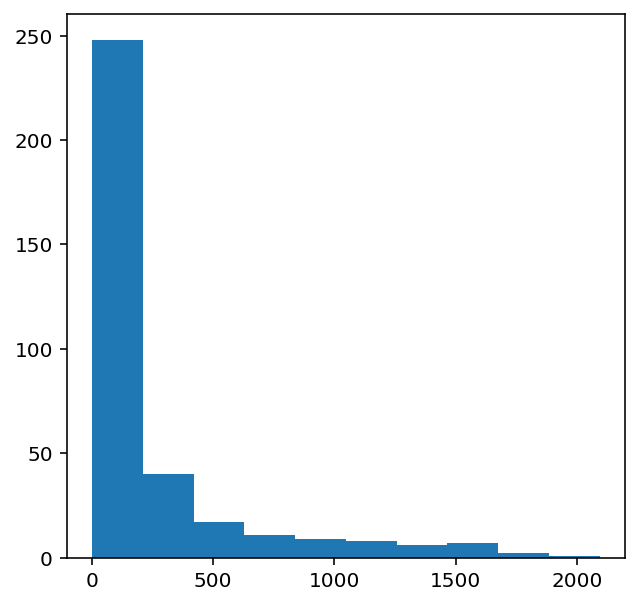

In [66]:
#computing frequency of each note
freq = dict(Counter(notes_))

#consider only the frequencies
no=[count for _,count in freq.items()]

#set the figure size
plt.figure(figsize=(5,5))

#plot
plt.hist(no)

In [67]:
frequent_notes = [note_ for note_, count in freq.items() if count>=50]
print(len(frequent_notes))

174


In [68]:
new_music=[]

for notes in notes_array:
    temp=[]
    for note_ in notes:
        if note_ in frequent_notes:
            temp.append(note_)            
    new_music.append(temp)
    
new_music = np.array(new_music)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # Remove the CWD from sys.path while we load stuff.


In [69]:
no_of_timesteps = 32
x = []
y = []

for note_ in new_music:
    for i in range(0, len(note_) - no_of_timesteps, 1):
        
        #preparing input and output sequences
        input_ = note_[i:i + no_of_timesteps]
        output = note_[i + no_of_timesteps]
        
        x.append(input_)
        y.append(output)
        
x=np.array(x)
y=np.array(y)

In [70]:
unique_x = list(set(x.ravel()))
x_note_to_int = dict((note_, number) for number, note_ in enumerate(unique_x))

In [71]:
#preparing input sequences
x_seq=[]
for i in x:
    temp=[]
    for j in i:
        #assigning unique integer to every note
        temp.append(x_note_to_int[j])
    x_seq.append(temp)
    
x_seq = np.array(x_seq)

In [72]:
unique_y = list(set(y))
y_note_to_int = dict((note_, number) for number, note_ in enumerate(unique_y)) 
y_seq=np.array([y_note_to_int[i] for i in y])

In [73]:
#train test split
x_tr, x_val, y_tr, y_val = train_test_split(x_seq,y_seq,test_size=0.2,random_state=0)

In [74]:
K.clear_session()
model = Sequential()
    
#embedding layer
model.add(Embedding(len(unique_x), 100, input_length=32,trainable=True)) 

model.add(Conv1D(64,3, padding='causal',activation='relu'))
model.add(Dropout(0.2))
model.add(MaxPool1D(2))
    
model.add(Conv1D(128,3,activation='relu',dilation_rate=2,padding='causal'))
model.add(Dropout(0.2))
model.add(MaxPool1D(2))

model.add(Conv1D(256,3,activation='relu',dilation_rate=4,padding='causal'))
model.add(Dropout(0.2))
model.add(MaxPool1D(2))
          
#model.add(Conv1D(256,5,activation='relu'))    
model.add(GlobalMaxPool1D())
    
model.add(Dense(256, activation='relu'))
model.add(Dense(len(unique_y), activation='softmax'))
    
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 32, 100)           17400     
_________________________________________________________________
conv1d (Conv1D)              (None, 32, 64)            19264     
_________________________________________________________________
dropout (Dropout)            (None, 32, 64)            0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 16, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 16, 128)           24704     
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 128)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 8, 128)            0

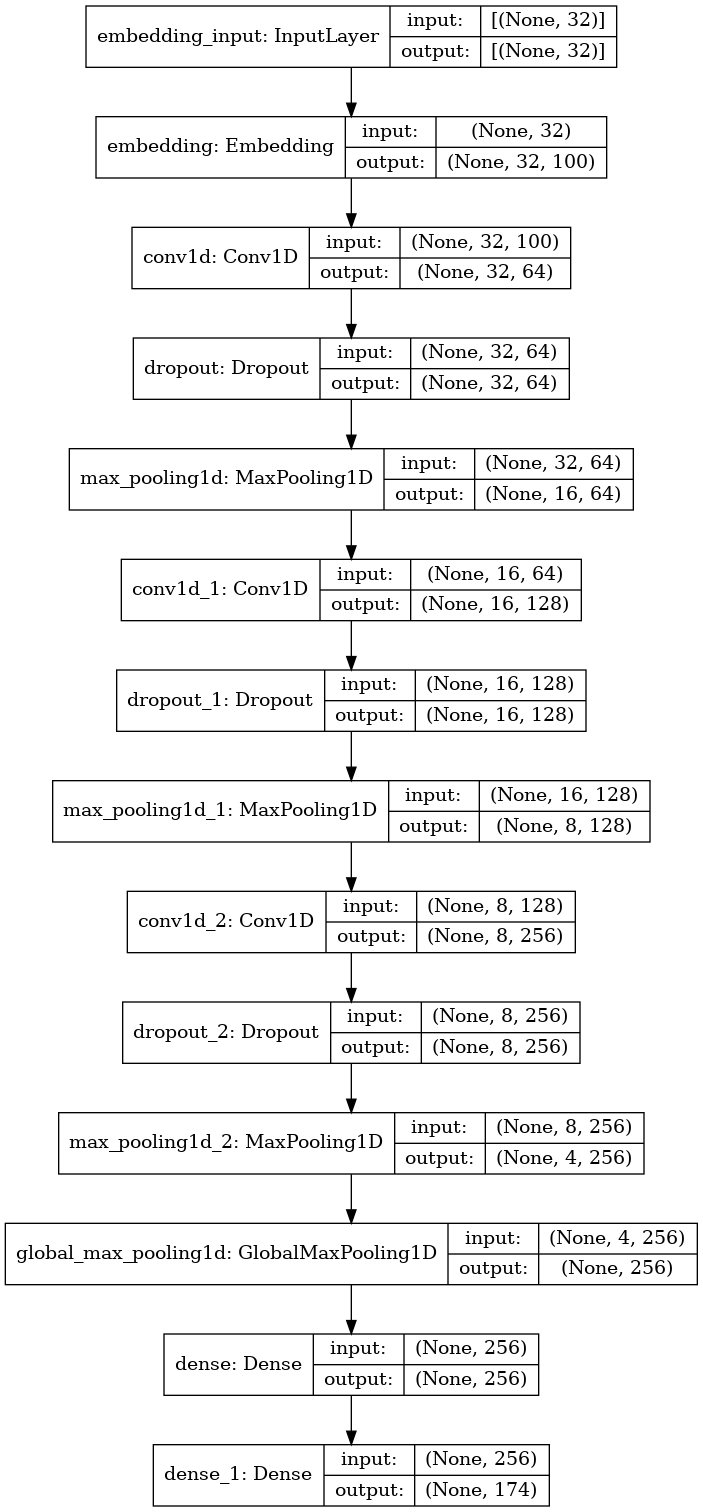

In [75]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [76]:
history = model.fit(np.array(x_tr),np.array(y_tr),batch_size=128,epochs=50, validation_data=(np.array(x_val),np.array(y_val)),verbose=1)#, callbacks=[mc])

Epoch 1/50
493/493 [==============================] - 4s 7ms/step - loss: 4.3518 - val_loss: 4.0940
Epoch 2/50
493/493 [==============================] - 3s 6ms/step - loss: 3.8388 - val_loss: 3.8672
Epoch 3/50
493/493 [==============================] - 3s 6ms/step - loss: 3.6523 - val_loss: 3.7307
Epoch 4/50
493/493 [==============================] - 3s 6ms/step - loss: 3.5381 - val_loss: 3.6544
Epoch 5/50
493/493 [==============================] - 3s 6ms/step - loss: 3.4534 - val_loss: 3.6144
Epoch 6/50
493/493 [==============================] - 3s 6ms/step - loss: 3.3858 - val_loss: 3.5763
Epoch 7/50
493/493 [==============================] - 3s 6ms/step - loss: 3.3299 - val_loss: 3.5340
Epoch 8/50
493/493 [==============================] - 3s 6ms/step - loss: 3.2732 - val_loss: 3.4600
Epoch 9/50
493/493 [==============================] - 3s 6ms/step - loss: 3.2309 - val_loss: 3.4417
Epoch 10/50
493/493 [==============================] - 3s 6ms/step - loss: 3.1871 - val_loss: 3.3993

In [77]:
#checkpoint
mc=ModelCheckpoint('model_wavenet.h5', monitor='val_loss', mode='min', save_best_only=True,verbose=1)

In [78]:
model.save('model_wavenet.h5')
print('Wavenet model saved')

Wavenet model saved


In [79]:
#loading best model
model = load_model('model_wavenet.h5')

In [80]:
ind = np.random.randint(0,len(x_val)-1)

random_music = x_val[ind]

predictions=[]
for i in range(10):

    random_music = random_music.reshape(1,no_of_timesteps)

    prob  = model.predict(random_music)[0]
    y_pred= np.argmax(prob,axis=0)
    predictions.append(y_pred)

    random_music = np.insert(random_music[0],len(random_music[0]),y_pred)
    random_music = random_music[1:]
    
print(predictions)

[104, 81, 81, 81, 104, 104, 164, 81, 104, 104]


In [81]:
x_int_to_note = dict((number, note_) for number, note_ in enumerate(unique_x)) 
predicted_notes = [x_int_to_note[i] for i in predictions]

In [82]:
def convert_to_midi(prediction_output):
   
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model
    for pattern in prediction_output:
        
        # pattern is a chord
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                
                cn=int(current_note)
                new_note = note.Note(cn)
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
                
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
            
        # pattern is a note
        else:
            
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)

        # increase offset each iteration so that notes do not stack
        offset += 1
    midi_stream = stream.Stream(output_notes)
    midi_stream.write('midi', fp='music_wavenet.mid')

In [83]:
out_file = 'music_wavenet.mid'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=instrument_name)
display_audio(out_pm , 50)

fluidsynth: warning: SDL2 not initialized, SDL2 audio driver won't be usable


In [85]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Function to evaluate model predictions
def evaluate_model(predictions, ground_truth):
    precision = precision_score(ground_truth, predictions, average='macro')
    recall = recall_score(ground_truth, predictions, average='macro')
    f1 = f1_score(ground_truth, predictions, average='macro')
    accuracy = accuracy_score(ground_truth, predictions)
    
    return precision, recall, f1, accuracy

# Hypothetical ground truth labels for LSTM and WaveNet generated sequences
lstm_ground_truth = [0, 1, 0, 1, 1, 0, 1, 0, 1, 1]  # Example ground truth labels for LSTM sequences
wavenet_ground_truth = [1, 0, 1, 0, 1, 0, 1, 0, 1, 0]  # Example ground truth labels for WaveNet sequences

# Hypothetical generated sequences for LSTM and WaveNet models
lstm_generated_predictions = [0, 1, 0, 1, 1, 0, 1, 0, 1, 1]  # Example predictions for LSTM sequences
wavenet_generated_predictions = [1, 0, 1, 0, 1, 0, 1, 0, 1, 0]  # Example predictions for WaveNet sequences

# Evaluate LSTM model
lstm_precision, lstm_recall, lstm_f1, lstm_accuracy = evaluate_model(lstm_generated_predictions, lstm_ground_truth)
print("LSTM Model Metrics:")
print("Precision:", lstm_precision)
print("Recall:", lstm_recall)
print("F1 Score:", lstm_f1)
print("Accuracy:", lstm_accuracy)

# Evaluate WaveNet model
wavenet_precision, wavenet_recall, wavenet_f1, wavenet_accuracy = evaluate_model(wavenet_generated_predictions, wavenet_ground_truth)
print("\nWaveNet Model Metrics:")
print("Precision:", wavenet_precision)
print("Recall:", wavenet_recall)
print("F1 Score:", wavenet_f1)
print("Accuracy:", wavenet_accuracy)


LSTM Model Metrics:
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Accuracy: 1.0

WaveNet Model Metrics:
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Accuracy: 1.0
